In [1]:
import arviz as az
import networkx as nx
import numpy as np
import pandas as pd
from pywhy_graphs.viz import draw
import pymc as pm
from scipy import stats
import warnings

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
warnings.filterwarnings('ignore')

References

* https://github.com/pymc-devs/pymc/discussions/5066
* https://www.isaacslavitt.com/posts/dirichlet-multinomial-for-skittle-proportions/
* https://github.com/pymc-devs/pymc/pull/4773

1\. The data in data(bangladesh) are 1934 women from the 1989 BangladeshFertility Survey. For each woman, we know which district she lived in, her number of living.children, her age.centered, whether she lived in an urban center, and finally whether or not she used contraception (use.contraception).
In the lecture, we estimated the total effect of urban residence on contraceptive use. Using the DAG from lecture, or your own version if you prefer, now estimate only the direct effect of urban residence on contraceptive use.

In [3]:
d = pd.read_csv("../../Data/bangledesh.csv", sep=";", header=0)
d

,woman,district,use.contraception,living.children,age.centered,urban
0,1,1,0,4,18.4400,1
1,2,1,0,1,-5.5599,1
2,3,1,0,3,1.4400,1
3,4,1,0,4,8.4400,1
4,5,1,0,1,-13.5590,1
...,...,...,...,...,...,...
1929,1930,61,0,4,14.4400,0
1930,1931,61,0,3,-4.5599,0
1931,1932,61,0,4,14.4400,0
1932,1933,61,0,1,-13.5600,0


In [4]:
d.dtypes

woman                  int64
district               int64
use.contraception      int64
living.children        int64
age.centered         float64
urban                  int64
dtype: object

In [5]:
d2 = d.copy()
d2["age.centered"] = stats.zscore(d["age.centered"])

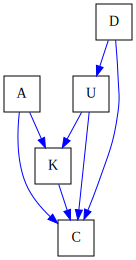

In [7]:
G = nx.DiGraph([("A", "C"), ("K", "C"), ("D", "C"), ("U", "C"), ("A", "K"), ("U", "K"), ("D", "U"), ("U", "K")])
draw(G, node_shapes="o")

http://dagitty.net/dags.html?id=uL7V8X

The total effect only of U needs only D, the district tendencies. Now the model for the direct effect must include all of the variables: K, A and D. Why? Because we need to condition on K to block the indirect effect through K. But K is a collider between A and U. So we also need to condition on A to block the collider confounding path that opens when we condition on K. Oh bother.

In [8]:
C = d2["use.contraception"]
D = d2.district
U = d2.urban
A = d2["age.centered"]
K = d2["living.children"]
num_Ds = max(D) + 1

with pm.Model() as m1_1:
    a_bar = pm.Normal("a_bar", 0., 1.)
    b_bar = pm.Normal("b_bar", 0., 1.)
    sigma = pm.Exponential("sigma", 1)
    tau = pm.Exponential("tau", 1)

    b = pm.Normal("b", b_bar, tau, shape=num_Ds)
    a = pm.Normal("a", a_bar, sigma, shape=num_Ds)

    p = pm.invlogit(a[D] + b[D]*U)
    C = pm.Bernoulli("C", p=p, observed=C)
    t1_1 = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_bar, b_bar, sigma, tau, b, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.


In [9]:
C = d2["use.contraception"]
D = d2.district
U = d2.urban
A = d2["age.centered"]
K = d2["living.children"] - 1

num_Ds = max(D) + 1
num_Ks = max(K)

with pm.Model() as m1_2:
    delta = pm.Dirichlet("delta", [2]*num_Ks)
    bK = pm.Normal("bK", 0., 1.)
    bA = pm.Normal("bA", 0., 1.)
    sigma = pm.Exponential.dist(1)
    rho, _, _ = pm.LKJCholeskyCov("rho", eta=4, n=2, sd_dist=sigma)
    a_bar = pm.Normal("a_bar", 0., 1., shape=2)
    v = pm.MvNormal("v", a_bar, chol=rho, shape=(num_Ds, 2))

    a = v[:, 0]
    b = v[:, 1]
    sum_k = [sum(x) for x in [delta[0:k] for k in K]]

    p = pm.invlogit(a[D] + b[D]*U + bA*A + bK*sum_k)
    C = pm.Bernoulli("C", p=p, observed=C)
    t1_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, bK, bA, rho, a_bar, v]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 743 seconds.


OverflowError: cannot convert float infinity to integer

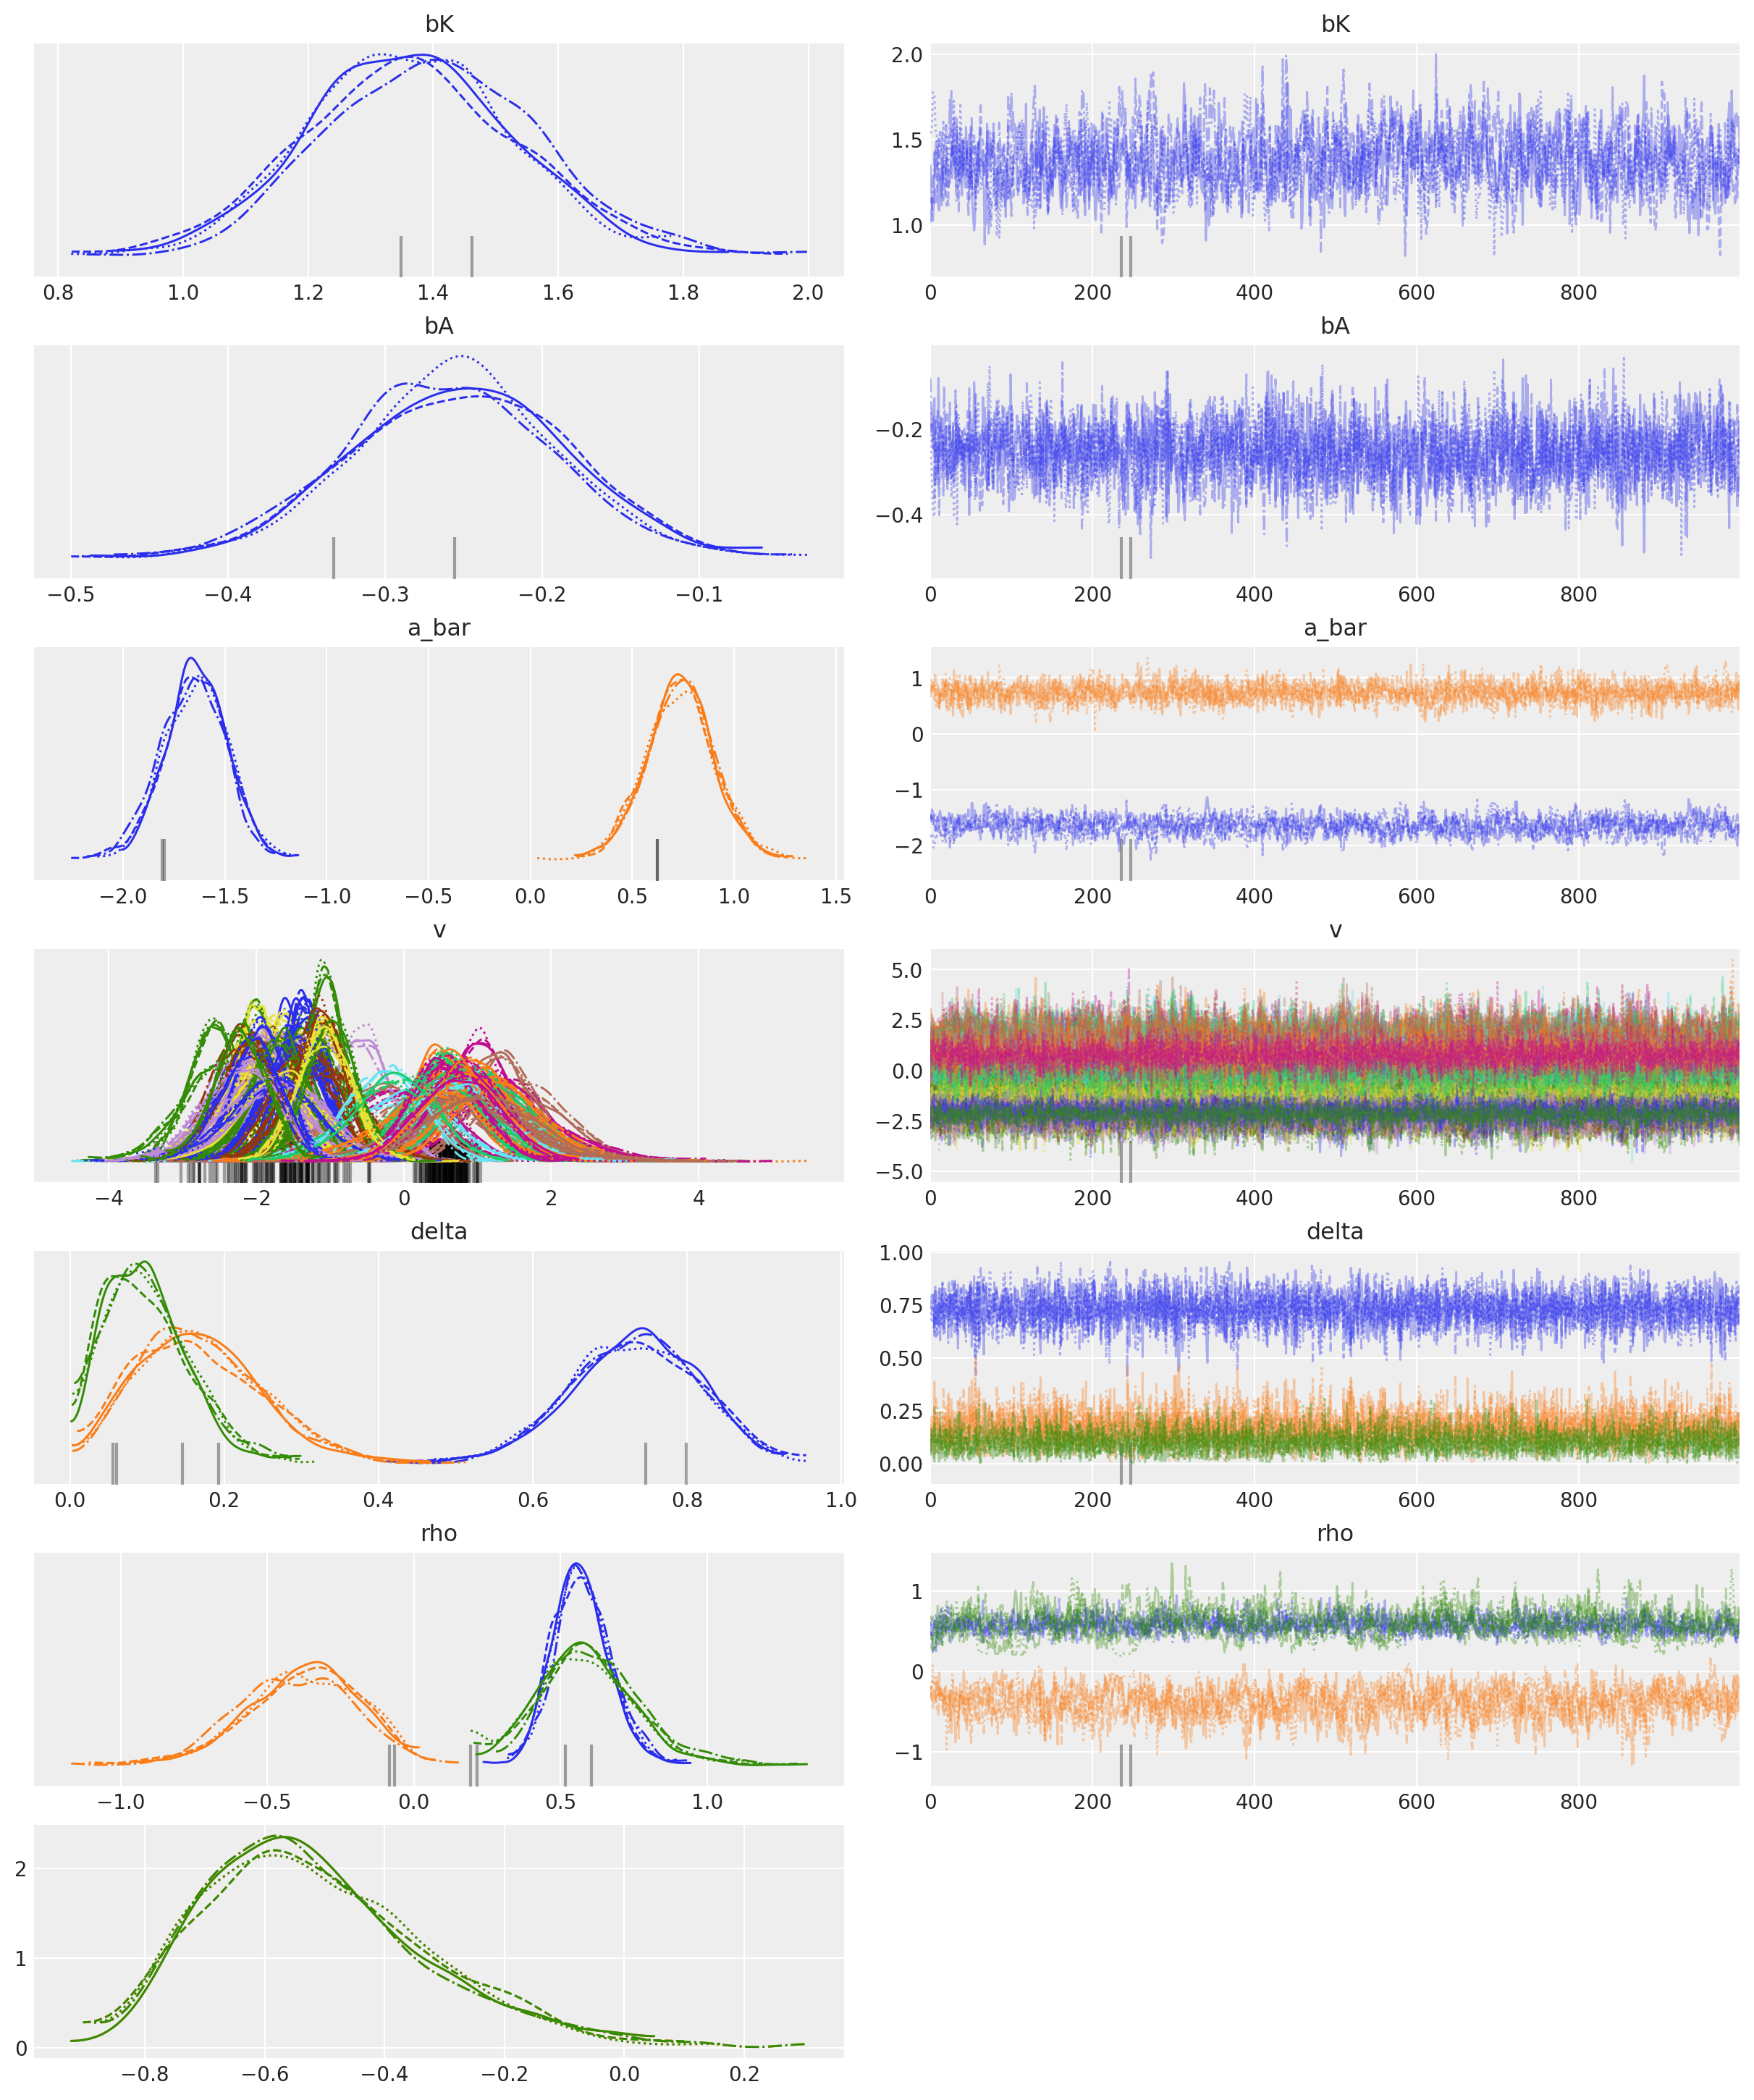

In [10]:
az.plot_trace(t1_2)

In [11]:
az.summary(t1_2, round_to=2, kind="stats")

,mean,sd,hdi_3%,hdi_97%
bK,1.37,0.17,1.06,1.68
bA,-0.25,0.07,-0.39,-0.13
a_bar[0],-1.65,0.15,-1.93,-1.36
a_bar[1],0.74,0.17,0.42,1.05
"v[0, 0]",-1.65,0.60,-2.78,-0.52
...,...,...,...,...
"rho_corr[0, 1]",-0.52,0.18,-0.80,-0.14
"rho_corr[1, 0]",-0.52,0.18,-0.80,-0.14
"rho_corr[1, 1]",1.00,0.00,1.00,1.00
rho_stds[0],0.57,0.10,0.40,0.77


2\. Using the same DAG as before, now estimate the effect of number of surviving children on contraceptive use. Obviously contraceptive use can also influence the number of surviving children. But leave that issue aside for the moment (it will return in the optional challenge further down).


3\. Now let the causal effect of children vary by district. Incorporate this new district feature into the same multivariate prior that contains the urban/rural features. How much do districts vary in how surviving children are associated with contraceptive use?